In [ ]:
# Variational data assimilation demonstration
# Previous versions. JA, PJS
# Last revision: April 2023. RNB

import numpy as np
from numpy import linalg
from tools.L96_model import lorenz96
from tools.obs import createH, gen_obs
from tools.cov import getBcanadian
from tools.plots import plotL96, plotL96obs, plotL96DA_var, plotL96_obs_vs_modelobs, \
                        make_histogram, plot_log_test, plotH, plot_matrix, tileplotB
from tools.L96_model import Lorenz96_TL_propogation, Lorenz96_TL_propogation_adj
from tools.L96_model import Lorenz96_TL1, Lorenz96_TL1_adj
from tools.L96_model import Lorenz96_TL_simple, Lorenz96_TL_simple_adj
from tools.L96_model import Lorenz96_TL1_simple, Lorenz96_TL1_simple_adj
from tools.variational import var3dL96, var4dL96

# Variational data assimilation with the Lorenz 96 model

This exercise allows you to explore traditional variational data assimilation
techniques (i.e. methods that assimilate data by minimising a cost
function, where the $\mathbf{B}$-matrix in that cost function is
a fixed matrix). The methods are called 3D-Var (where there is no
evolution of the state within an assimilation window), and 4D-Var
(where there is evolution of the state, which allows observations
that are at a later time than the analysis to be properly assimilated).

From the lectures, the 3D-Var cost function to be explored is of the
'full-fields' (non-incremental) variety:
\begin{equation}
J^{3\mathrm{D}}(\mathbf{x})=\frac{1}{2}\left(\mathbf{x}-\mathbf{x}^{\mathrm{b}}\right)^{\mathrm{T}}\mathbf{B}_{0}^{-1}\left(\vphantom{\mathbf{x}^{\mathrm{b}}}\bullet\right)+\frac{1}{2}\sum_{i=0}^{T}\left(\mathbf{y}_{i}-\mathcal{H}_{i}(\mathbf{x}_{i}^{\mathrm{R}})-\mathbf{H}_{i}\mathbf{x}\right)^{\mathrm{T}}\mathbf{R}_{i}^{-1}\left(\vphantom{\mathbf{x}_{i}^{\mathrm{R}}}\bullet\right),
\end{equation}
and the 4D-Var cost function is of the incremental variety:
\begin{equation}
J(\delta\mathbf{x}_{0})=\frac{1}{2}\delta\mathbf{x}_{0}^{\mathrm{T}}\mathbf{B}_{0}^{-1}\delta\mathbf{x}_{0}+\frac{1}{2}\sum_{i=0}^{T}\left(\mathbf{y}_{i}-\mathcal{H}_{i}(\mathbf{x}_{i}^{\mathrm{b}})-\mathbf{H}_{i}\mathbf{M}_{i-1}\mathbf{M}_{i-2}\ldots\mathbf{M}_{0}\delta\mathbf{x}_{0}\right)^{\mathrm{T}}\mathbf{R}_{i}^{-1}\left(\vphantom{\mathbf{x}_{i}^{\mathrm{b}}}\bullet\right).
\end{equation}
These assimilation methods will be demonstrated with the simple Lorenz
96 model, which is described by the following set of coupled ordinary
differential equations:
\begin{equation}
\frac{dx_{k}}{dt}=x_{k-1}\left(x_{k+1}-x_{k-2}\right)-x_{k}+F,
\end{equation}
where the subscripts indicate the grid position. Together, all of
the $x_{k}$ values make up the vector $\mathbf{x}$.

There will be a number of tasks to perform.

1. Choose some parameters, which describe things like the model configuration,
the model timestep, and the length of the total assimilation period.
2. Perform and plot a 'nature run' of the model. This will allow you
to get a feel for how the model evolves, and to form a 'base truth',
which will be used to simulate some observations. The observations
will later be assimilated with 3D and 4D-Var to see how well the truth
can be recovered.
3. Estimate a $\mathbf{B}$-matrix. This was explored in an earlier exercise,
and so you may wish to use the same matrix from then.
4. Choose an observation network out of a set of options. Some of the
network options observe directly the model state, $x_{k}$ (either
all model grid points $k$, or a sub-set of model grid points), and
other options observe the state indirectly. The same observation network
is used at various points in time to:
4a. Generate the observations from the base truth and
4b. To define the observation operator, $\mathbf{H}$, used in the assimilation.
5. Run full-fields 3D-Var over a number of data assimilation cycles.
For the purposes of this exercise, the 3D-Var window is defined to
be the same as the chosen time separation between observation sets.
This means that for each assimilation, the state and the observations
exist at the same time. This means that the 3D-Var makes no approximations
regarding the different validity times of the analysis and observation
times. A number of diagnostics will be plotted automatically to help
you assess how well the assimilation is performed.
6. Do some tests in preparation for incremental 4D-Var. This includes linearisation and adjoint tests.
7. Run incremental 4D-Var over a number of data assimilation cycles.
The observations can be chosen to be at the same, or later, times
from the analysis. This allows 4D-Var to construct a trajectory to
fit observations over a time window, which allows dynamical information
to be included in the assimilation (in addition to the generation
of the background state as a forecast, which is used in 3D and 4D-Var).
Again a number of diagnostics will be plotted automatically.



## 1. Choose the set-up
Choosing a set of parameters allows you to generate a 'truth' and
to set the scope of the assimilation experiments. $n$ is the number
of state variables ($1\leq k\leq n$), $F$ is the model forcing,
$\delta t$ is the model time step, and $t_{\mathrm{f}}$ is the final
time of the assimilation. The initial state is also set. Since the
initial state may take a period of time for any initial imbalances
to dissipate and for the model to move towards its attractor, a specified
number of time steps may be performed (variable 'discard') before
the nominal 'zero' of time is reached.

In [ ]:
n      = 12             # No. of state variables (No. of nodes in Lorenz-96, often n=40)
F      = 8.0            # Forcing F>5.0 guarantees chaos
deltat = 0.025          # Model timestep
tf     = 10.0           # The final time of the simulation

# Set the true initial conditions to something plus a perturbation
# This can be spun-up by discarding the first number of steps
x0     = np.repeat(10.0, n)
x0[1] += 0.05

# Call the model integration scheme and output a time sequence
# Discard the first number of model time steps (spin-up) - this is done inside lorenz96
discard = 150

# Set the timesteps
t = np.arange(0.0, tf+deltat/2.0, deltat)

## 2. Run the model
Run the model for the 'truth' using the subroutine 'lorenz96', and plot the result. A Hovmoller plot is shown, which is a time vs state plot. Can you identify the propagation of features within the one-dimensional domain? If you were to stand at a particular point in this model world you would experience oscillations in 'weather'.

In [ ]:
# Run the model for the truth trajectory
xtrue_traj = lorenz96(x0, tf, deltat, discard, F)

# Plot the truth
plotL96 (t, xtrue_traj, n, 'Lorenz 96 system (truth)')

## 3. Estimate a B-matrix
This was explored in the previous exercise and uses the Canadian quick
method. Calibrating a $\mathbf{B}$-matrix requires a population of
perturbation states, $\delta\mathbf{x}$ (proxies for forecast error)
in order to compute $\left\langle \delta\mathbf{x}\delta\mathbf{x}^{\mathrm{T}}\right\rangle $.
The Canadian method takes a single model run (we use the same initial
conditions as used for the truth performed earlier -- after discarded
steps) and assumes that $\delta\mathbf{x}\sim\mathbf{x}_{t+\Delta}-\mathbf{x}_{t}$,
where the subscripts represent the validity time, and $\Delta$ is
the lag.

Choose a 'lag', and a 'sample_size'. You may also choose a value
of 'max_var'. If this is set to a numerical value then this scales
the emerging $\mathbf{B}$-matrix so it has the specified maximum
variance. You may wish to use the same parameters that you used in
the previous exercise. Run 'getBcanadian' to generate the matrix and
then plot it.

In [ ]:
# The following code estimates {\bf B} using the Canadian Quick method for the Lorenz 96 model.
lag         = int(0.1/deltat) # the lag, T, in number of time steps,
                    # 6 hours is about 0.05 time units, one period of system is about 1.8 time units
sample_size = 10000 # number of samples to estimate B (create a climatological matrix)
max_var     = None #2# # if set scales the estimated B to have a maximum variance
xB  = lorenz96(xtrue_traj[:,0], sample_size*deltat, deltat, 0, F)
B,Bcorr     = getBcanadian (xB, lag, max_var, sample_size)

# set plot properties and then plot
mycmap      = 'BrBG'
vs          = [-np.amax(np.diag(B)),np.amax(np.diag(B))]
tileplotB(B, mycmap, vs)

## 4. Choose an observation network
You can choose various options for the variable 'obsgrid', which will
specify the $\mathbf{H}$ operator:
* all: this chooses $\mathbf{H}=\mathbf{I}$. It means that there are
$n$ direct observations (at each time observations are asked for
-- see below).
* 1010: this specifies that direct observations are made at every other
grid point. There are $n/2$ observations at each observation time.
* landsea: this simulates the effect of observing directly only half
of the domain (in reality there are many more observations over land
than over sea). This option assigns half of the grid points to 'land'
and the other half as 'sea', where there are observation over land
only. There are $n/2$ observations at each observation time.
* foot_cent: this simulates a single ($n=1$) indirect observation
in the centre of the domain. A linear combination of grid points is
observed with different weights (specified by a truncated Gaussian
function).
* foot_6: this is similar to 'foot\_cent', but there are six such truncated
Gaussian footprints spread evenly throughout the domain ($n=6$).
With this option you can also set the footprint size in grid points
(variable 'footprint').

The last two options 'foot_cent' and 'foot_6' are meant to represent
satellite-like observations which may 'see' more than one model grid
point (a footprint).

Other options include 'period_obs', which specifies the number of
timesteps between the observations being made, 'var_obs', the error
variance of the observations, and 'seed', the random number seed.
Choosing the same seed will produce the same set of pseudo-random
observations each time you run the code. If you are in doubt about
what to choose for the observation error variances, a good choice
may be to assess the 'typical' variation of the fields from the truth
run, take about 10% of it and square it. Of course in reality the
observation error variances used will depend on the instruments used
to make the observations (plus in data assimilation any representivity
error variances), but the "10% squared" rule should produce an
appropriate value for our tests. You can later vary this up and down
to see the effect of different precision instruments.

The following subroutines can then be run:
1. Run 'createH' to generate a matrix $\mathbf{H}$. Plot this matrix
to understand its structure for your chosen observation network (try
different networks to understand how $\mathbf{H}$ changes).
2. Generate the set of observations over the entire time domain ($t_{\mathrm{f}}$)
by running 'gen\_obs'. This also generates an array containing the
observation times, and the observation error covariance matrix, $\mathbf{R}$,
which here is the same for each observation time. Plot the observations
(in a similar way to the truth being plotted above), and the observation
error covariance matrix.

In [ ]:
obsgrid    = 'all'  # 'all': observe all variables
                    # '1010': observe every other variable,
                    # 'landsea': observe only half of domain
                    # 'foot_cent': single obs of a footprint (truncated Gaussian at centre of domain)
                    # 'foot_6': six obs of a footprint (truncated Gaussians throughout the domain)
                    #           This has an additional parameter 'footprint', which governs how many grid points are observed.
period_obs = 2      # number of time steps between observations
var_obs    = 2.0    # observation error variance
seed       = 1      # random number seed
footprint  = 3      # number of gridpoints observed by one variable for the obsgrid='foot_6' option

# Create the observation operator matrix
p, H = createH(obsgrid, n, footprint)

# Plot the observation operator matrix
plotH(H)

# Generate synthetic observations, ob err cov matrix, and return their validity times
tobs, y, R = gen_obs(t, xtrue_traj, period_obs, H, var_obs, seed)

# Plot the observations
plotL96obs (tobs, y, p, 'L96 observations')

# Plot the observation error covariance matrix')
mycmap = 'BrBG'
vs     = [-np.amax(np.diag(R)),np.amax(np.diag(R))]
tileplotB(R, mycmap, vs)

## 5. Run full-fields 3D-Var
As explained above, data assimilation cycling is performed over the
total time period $t_{\mathrm{f}}$ with observations every 'period_obs'
timesteps according to the observation network specified previously.
In this implementation of 3D-Var, the analysis times (yellow lines
in the Fig.) are the same as the observation times (red circles).

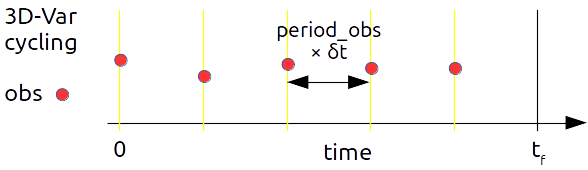


The initial background (the background for the first cycle) is taken
to be the initial truth plus some white noise (white noise is a special
form of noise that is uncorrelated). Adding white noise to a model
state is likely to yield a state that is removed from the model's
attractor; this may appear as a large error in the state initially,
which should reduce as the assimilation cycles proceed. Can you think
of an alternative method of perturbing a model state which is not
likely to have this problem?

1. Run the 'var3dL96' subroutine. This will produce three trajectories,
one labeled 'background' (here this is a forecast over each assimilation
period starting from the background), another labeled 'analysis' (this
is a forecast over the assimilation period starting from the 3D-Var
analysis), and the truth. Remember that the background state, $\mathbf{x}^{\mathrm{b}}$,
is itself a forecast starting from the previous cycle's analysis.
2. Before the 3D-Var is run in 'var3dL96', you may request a gradient test to be performed
(gradtest=True in the call to 'var3dL96'). If requested this is shown.
This plots the quantity $\Phi(\alpha)-1$ for a range of $\alpha$,
where
\begin{equation}
\Phi(\alpha)-1=\frac{J(\mathbf{x}+\alpha\mathbf{h})-J(\mathbf{x})}{\alpha\mathbf{h}^{\mathrm{T}}\nabla J(\mathbf{x})}-1=O(\alpha),
\end{equation}
where $\mathbf{h}$ is a unit vector in any direction in state space.
The particular direction chosen for the gradient test is $\mathbf{h}=\nabla J(\mathbf{x})/\left\Vert \nabla J(\mathbf{x})\right\Vert $.
3. Plot the trajectories for each model variable. If the observations
are direct observations ('all', '1010', or 'landsea') then the observations
will also be shown. The vertical yellow lines indicate the analysis
times.
4. Plot other diagnostics (observations vs. the background's or analysis's
version of the observations), and background or analysis minus truth
histograms.

Make a note of the quality of the results and go back and try different
configurations. Try thinking about the following.
1. Change the obsgrid option. For example, try the options that make
fewer observations and investigate the effect on the performance of
the data assimilation.
2. Change the periodobs variable. How large can this be before the assimilation
is unable to perform well.

In [ ]:
xb_traj, xa_traj = var3dL96 (x0, t, tobs, y, H, B, R, F, gradtest=True)

# Plot truth, background, and analysis
plotL96DA_var (t, xtrue_traj , xb_traj, xa_traj, tobs, y, tobs, H, R, '3D-Var results')

# Plot obs vs truth
plotL96_obs_vs_modelobs (xtrue_traj, y, H, period_obs, 'obs vs modelobs (truth)')

# Plot obs vs background
plotL96_obs_vs_modelobs (xb_traj, y, H, period_obs, 'obs vs modelobs (background)')

# Plot obs vs analysis
plotL96_obs_vs_modelobs (xa_traj, y, H, period_obs, 'obs vs modelobs (analysis)')

#Plot error histograms
make_histogram (30, xtrue_traj, xb_traj, t, tobs, '3D-Var background error distribution')
make_histogram (30, xtrue_traj, xa_traj, t, tobs, '3D-Var analysis error distribution')

## Preparation for incremental 4D-Var
For this implementation of 4D-Var the cycling will again be performed
over the total time period $t_{\mathrm{f}}$ with observations every
'period\_obs' timesteps. Unlike for 3D-Var, the analysis will be performed
every 'anawin' observation periods (see the Fig., where period\_obs
= 2). Having observations at times later than the analysis times will
allow 4D-Var to fit a model trajectory to the data (over $\mathrm{period_obs}\times\mathrm{anawin}\times\delta t$)
rather than just doing static fitting at each analysis.

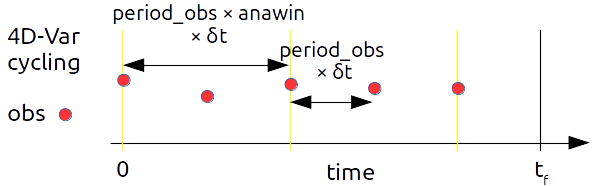

Before running 4D-Var we look at aspects of the tangent linear model
(already coded as a subroutine), including how well it propagates
perturbations (compared to the non-linear model), whether is has been
coded correctly, and whether the adjoint has been coded correctly.
To run the code, you will need to first choose a value of $\textrm{anawin}\geq2$.

In [ ]:
# Length of assimilation window, expressed as multiple of obs frequency
# number of observations per window
anawin   = 5
cyclelen = period_obs * anawin  # The number of timesteps in a 4DVar window
tf1      = cyclelen * deltat    # The period of time

Now set-up a perturbation, $\delta\mathbf{x}$. This is constructed
as a white noise perturbation (as we did earlier to construct the
initial background in the 3D-Var experiments).

In [ ]:
# Need to set-up a perturbation - how large should it be?
av_var = 0.0
for el in range(n):
  av_var += B[el,el]
av_var /= float(n)
# Set up a random perturbation at t=0
xp0 = np.sqrt(av_var) * np.random.randn(n)

The evolution of perturbations is studied by running a pair of non-linear
model trajectories: (i) $\mathbf{x}_{\tau}^{\mathrm{unpert}}=\mathcal{M}_{0\rightarrow\tau}(\mathbf{x}_{0})$
and (ii) $\mathbf{x}_{\tau}^{\mathrm{pert}}=\mathcal{M}_{0\rightarrow\tau}(\mathbf{x}_{0}+\delta\mathbf{x}_{0})$
for $0\leq\tau\leq\textrm{period\_ob}\times\textrm{anawin}\times\delta t$.
The difference between these is compared to a single run of the tangent
linear model, $\delta\mathbf{x}_{\tau}^{\mathrm{TLM}}=\mathbf{M}_{0\rightarrow\tau}\delta\mathbf{x}_{0}$.

1. Run lorenz96 for the unperturbed and perturbed initial conditions
and Lorenz96\_TL\_propagation for the initial perturbation and plot
the difference between the two non-linear trajectories, $\mathbf{x}_{\tau}^{\mathrm{pert}}-\mathbf{x}_{\tau}^{\mathrm{unpert}}$,
and the linear perturbation, $\delta\mathbf{x}_{\tau}^{\mathrm{TLM}}$.
4D-Var makes the approximation that these two are the same. Plot the
difference $\delta\mathbf{x}_{\tau}^{\mathrm{TLM}}-\left(\mathbf{x}_{\tau}^{\mathrm{pert}}-\mathbf{x}_{\tau}^{\mathrm{unpert}}\right)$
to see how large the error is by making the linear approximation.
2. Do a correctness test. The above difference plot should go to zero
as size of the perturbation goes to zero. A correctness test does
this by testing that the linear term has been fully captured by the
linearisation procedure in the subroutine Lorenz96\_TL\_propagation.
The correctness test diagnostic find the following quantity for a
range of values of small values of $\gamma$:
\begin{equation}
\frac{\left\Vert \mathcal{M}_{0\rightarrow\tau}(\mathbf{x}_{0}+\gamma\delta\mathbf{x}_{0})-\mathcal{M}_{0\rightarrow\tau}(\mathbf{x}_{0})-\mathbf{M}_{0\rightarrow\tau}\gamma\delta\mathbf{x}_{0}\right\Vert }{\left\Vert \mathbf{M}_{0\rightarrow\tau}\gamma\delta\mathbf{x}_{0}\right\Vert }.
\end{equation}
In the limit as $\gamma\rightarrow0$, this quantity should go to
zero. This can be demonstrated by showing that the above quantity
scales linearly with $\gamma$. Plot this to see if this is correct.
Why would you expect this quantity to scale linearly with $\gamma$?
Can you explain any features that don't satisfy this requirement?

In [ ]:
, F# Run the baseline non-linear trajectory over a cycle window
x_unpert_traj  = lorenz96(x0, tf1, deltat, 0, F)

# Run with the perturbation
x_pert_traj = lorenz96(x0+xp0, tf1, deltat, 0, F)

# Run the tangent linear (TL) model for the same length of time with the specified perturbation
# Note that the TL model runs for the same number of steps as in x_unpert_traj
xp_traj = Lorenz96_TL_propogation (xp0, cyclelen, x0, F, deltat)

# Plot the perturbation propagation with time ...
# ... as the difference between two non-linear trajectories
plotL96 (t[0:cyclelen+1], x_pert_traj-x_unpert_traj, n, 'Lorenz 96 system - NL pert')
# ... as a linear perturbation ...
plotL96 (t[0:cyclelen+1], xp_traj, n, 'Lorenz 96 system - TL pert')
# ... and the difference between the two (want this to be as small as possible)
plotL96 (t[0:cyclelen+1], xp_traj-(x_pert_traj-x_unpert_traj), n, 'Lorenz 96 system - pert diff')


# Do a correctness test to see if the linearisation has been coded correctly
# Magnitude of the pert at the end of the trajectory
magp0 = linalg.norm(xp_traj[:,-1], axis=0)

gamma_store = []
correctness = []
for loggamma in range(-10,1):
  # gamma is the multiple of the pert
  gamma = 10.0**float(loggamma)
  # Run a perturbed non-linear run of the model
  x_pert_traj = lorenz96(x0+gamma*xp0, tf1, deltat, 0, F)
  magp = linalg.norm(x_pert_traj[:,-1] - x_unpert_traj[:,-1] - gamma*xp_traj[:,-1], axis=0)
  # Store the result
  gamma_store.append(gamma)
  correctness.append(magp / (gamma * magp0))

plot_log_test (gamma_store, correctness, 'gamma', 'rel err', 'L96 TLM correctness test (correct TLM)')

4D-Var requires the adjoint, $\mathbf{M}_{t\rightarrow t+\delta t}^{\mathrm{T}}$,
of the tangent linear model, $\mathbf{M}_{t\rightarrow t+\delta t}$
(given here over one timestep). The adjoint test is passed if the
following is satisfied to machine precision:
\begin{equation}
\left(\mathbf{M}_{t\rightarrow t+\delta t}\delta\mathbf{x}\right)^{\mathrm{T}}\mathbf{M}_{t\rightarrow t+\delta t}\delta\mathbf{x}\overset{?}{=}\delta\mathbf{x}^{\mathrm{T}}\mathbf{M}_{t\rightarrow t+\delta t}^{\mathrm{T}}\mathbf{M}_{t\rightarrow t+\delta t}\delta\mathbf{x}
\end{equation}

In [ ]:
# Adjoint test of one time step of L96
# The forward code
xp1, xf = Lorenz96_TL1 (xp0, x0, F, deltat)
# Compute LHS
lhs = np.sum(xp1[:] * xp1[:])

# Run the adjoint code
xp0_hat = Lorenz96_TL1_adj (xp1, x0, F, deltat)
# Compute RHS
rhs = np.sum(xp0[:] * xp0_hat[:])

print ('Adjoint test of L96 one time-step subroutine')
print ('The following numbers should be the same to machine precision')
print ('lhs = ', lhs)
print ('rhs = ', rhs)

It is a good idea to also do an adjoint test for a whole sequence
of tangent linear models, 
\begin{equation}
\mathbf{M}_{0\rightarrow \mathrm{period_obs} \times \mathrm{anawin} \times \delta t} = \mathbf{M}_{0\rightarrow\delta t}\mathbf{M}_{\delta t\rightarrow2\delta t}\ldots\mathbf{M}_{\mathrm{period_obs}\times\mathrm{anawin}\times\delta t-\delta t\rightarrow\mathrm{period_obs}\times\mathrm{anawin}\times\delta t}
\end{equation}
to demonstrate that the linear time-stepping has been coded correctly.

In [ ]:
# Adjoint test of many time steps of L96
# The forward code
xp_traj = Lorenz96_TL_propogation (xp0, cyclelen, x0, F, deltat)
# Compute LHS
lhs = np.sum(xp_traj[:,-1] * xp_traj[:,-1])

# Run the adjoint code
xp0_hat = Lorenz96_TL_propogation_adj (xp_traj[:,-1], cyclelen, x0, F, deltat)
# Compute RHS
rhs = np.sum(xp0[:] * xp0_hat[:])

print ('Adjoint test of L96 many time-step subroutine')
print ('The following numbers should be the same to machine precision')
print ('lhs = ', lhs)
print ('rhs = ', rhs)

The tangent linear model actually coded in the 4D-Var is an approximation
to the one shown above. The one above properly linearises the fourth-order
Runge-Kutta scheme, which is used to solve the non-linear model. We
actually implement a simplified linearisation, which is quicker and
more convenient to code and use. We now test that. That linearisation
can use a simple Euler scheme, or a fourth-order Runge-Kutta scheme
(despite the latter name, it is still not a full linearisation of the non-linear
scheme).

We can investigate this simplified scheme in the same way to the full
scheme as above. First plot how the non-linear perturbations and linear
perturbations evolve, and do a correctness test. Does the simplified tangent linear
model perform qualitatively in a similar way to the correct tangent
linear model?

In [ ]:
TL_type  = '4RK'              # 'Euler' is simple Euler linearisation
                              # '4RK' is fourth order Runge-Kutta
# Run the baseline non-linear trajectory over a cycle window
x_unpert_traj  = lorenz96(x0, tf1, deltat, 0, F)

# Run with the perturbation
x_pert_traj = lorenz96(x0+xp0, tf1, deltat, 0, F)

# Run the (simplified) tangent linear (TL) model for the same length of time with the specified perturbation
# Note that the TL model runs for the same number of steps as in x_unpert_traj
xp_traj = Lorenz96_TL_simple (x_unpert_traj, xp0, deltat, TL_type)

# Plot the perturbation propagation with time ...
# ... as the difference between two non-linear trajectories
plotL96 (t[0:cyclelen+1], x_pert_traj-x_unpert_traj, n, 'Lorenz 96 system - NL pert')
# ... as a linear perturbation ...
plotL96 (t[0:cyclelen+1], xp_traj, n, 'Lorenz 96 system - TL pert')
# ... and the difference between the two (want this to be as small as possible)
plotL96 (t[0:cyclelen+1], xp_traj-(x_pert_traj-x_unpert_traj), n, 'Lorenz 96 system - pert diff')


# Do a correctness test to see if the linearisation has been coded correctly
# Magnitude of the pert at the end of the trajectory
magp0 = linalg.norm(xp_traj[:,-1], axis=0)

gamma_store = []
correctness = []
for loggamma in range(-10,1):
  # gamma is the multiple of the pert
  gamma = 10.0**float(loggamma)
  # Run a perturbed non-linear run of the model
  x_pert_traj = lorenz96(x0+gamma*xp0, tf1, deltat, 0, F)
  magp = linalg.norm(x_pert_traj[:,-1] - x_unpert_traj[:,-1] - gamma*xp_traj[:,-1], axis=0)
  # Store the result
  gamma_store.append(gamma)
  correctness.append(magp / (gamma * magp0))

plot_log_test (gamma_store, correctness, 'gamma', 'rel err', 'L96 TLM correctness test (' + TL_type + ' simplified)')

Now do the same adjoint tests that were performed before, but for
the simplified tangent linear model.

In [ ]:
# Adjoint test of one time step of L96
# The forward code
xp1 = Lorenz96_TL1_simple (x0, xp0, deltat, TL_type)
# Compute LHS
lhs = np.sum(xp1[:] * xp1[:])

# Run the adjoint code
xp0_hat = Lorenz96_TL1_simple_adj (x0, xp1, deltat, TL_type)
# Compute RHS
rhs = np.sum(xp0[:] * xp0_hat[:])

print ('Adjoint test of L96 one time-step subroutine')
print ('The following numbers should be the same to machine precision')
print ('lhs = ', lhs)
print ('rhs = ', rhs)


# Adjoint test of many time steps of L96
# The forward code
xp_traj = Lorenz96_TL_simple (x_unpert_traj, xp0, deltat, TL_type)
# Compute LHS
lhs = np.sum(xp_traj[:,-1] * xp_traj[:,-1])

# Run the adjoint code
xp0_hat = Lorenz96_TL_simple_adj (x_unpert_traj, xp_traj[:,-1], deltat, TL_type)
# Compute RHS
rhs = np.sum(xp0[:] * xp0_hat[:])

print ('Adjoint test of L96 many time-step subroutine')
print ('The following numbers should be the same to machine precision')
print ('lhs = ', lhs)
print ('rhs = ', rhs)

## Run incremental 4D-Var
As explained above, data assimilation cycling is performed over the
total time period $t_{\mathrm{f}}$ with observations every 'period\_obs'
timesteps according to the observation network specified previously,
but now we allow a number (anawin) of sets of observations spanned
over each analysis period (see the 4D-Var cycling Fig. shown previously).
We now run the 4D-Var and use the same (sub-optimal, but convenient)
way as for 3D-Var to choose an initial background state. The tasks
below are mirrors of the 3D-Var instructions.
1. Run the 'var4dL96' subroutine. This will produce three trajectories,
one labeled 'background' (here this is a forecast over each assimilation
period starting from the background), another labeled 'analysis' (this
is a forecast over the assimilation period starting from the 3D-Var
analysis), and the truth. Remember that the background state, $\mathbf{x}^{\mathrm{b}}$,
is itself a forecast starting from the previous cycle's analysis.
2. Before the 4D-Var is run in 'var4dL96', you may request a gradient
test to be performed (gradtest=True in the call to 'var4dL96'). If
requested this is shown. This plots the quantity $\Phi(\alpha)-1$
for a range of $\alpha$, where
\begin{equation}
\Phi(\alpha)-1=\frac{J(\mathbf{x}+\alpha\mathbf{h})-J(\mathbf{x})}{\alpha\mathbf{h}^{\mathrm{T}}\nabla J(\mathbf{x})}-1=O(\alpha),\qquad\textrm{where }\mathbf{h}=\frac{\nabla J(\mathbf{x})}{\left\Vert \nabla J(\mathbf{x})\right\Vert }.
\end{equation}
3. Plot the trajectories for each model variable. If the observations
are direct observations ('all', '1010', or 'landsea') then the observations
will also be shown. The vertical yellow lines indicate the analysis
times.
4. Plot other diagnostics (observations vs. the background's or analysis's
version of the observations), and background or analysis minus truth
histograms.

Make a note of the quality of the results and go back to compare against
the equivalent set-up with 3D-Var. You can also try different configurations.
Try thinking about the following.
* Change the obsgrid option. For example, try the options that make
fewer observations and investigate the effect on the performance of
the data assimilation.
* Change the periodobs variable. How large can this be before the assimilation
is unable to perform well.
* Change the length of the assimilation window by varying 'anawin'.
How long can this be before you 'break' the 4D-Var's assumptions?

In [ ]:
xb_traj, xa_traj = var4dL96 (x0, t, tobs, period_obs, anawin, y, H, B, R, F, TL_type, gradtest=True)

anal_times = np.arange(0.0, tf+deltat/2.0, deltat*float(cyclelen))

print ('Plotting truth, background, and analysis')
plotL96DA_var (t, xtrue_traj , xb_traj, xa_traj, tobs, y, anal_times, H, R, '4D-Var results')

print ('Plotting obs vs truth')
plotL96_obs_vs_modelobs (xtrue_traj, y, H, period_obs, 'obs vs modelobs (truth)')
print ('Plotting obs vs background')
plotL96_obs_vs_modelobs (xb_traj, y, H, period_obs, 'obs vs modelobs (background)')
print ('Plotting obs vs analysis')
plotL96_obs_vs_modelobs (xa_traj, y, H, period_obs, 'obs vs modelobs (analysis)')
print ('Plotting error histograms')
make_histogram (30, xtrue_traj, xb_traj, t, tobs, '4D-Var background error distribution')
make_histogram (30, xtrue_traj, xa_traj, t, tobs, '4D-Var analysis error distribution')